In [113]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from PIL import Image
import time
%matplotlib inline

In [114]:
class Network(object):
    
    def __init__(self, layer_node): #layer_node is a list contains the number of nodes in each layer
        self.num_layer = len(layer_node)
        self.layer_node = layer_node
        self.input_node = []
        #self.node = [ np.random.randn(num_node,1) for num_node in layer_node ]
        self.weights = [ np.random.randn(next_node,previous_node+1) for next_node, previous_node in zip(layer_node[1:],layer_node[:-1]) ]
        
    def add_input_node(self,input_vector): #must be of size (n,1)
        if len(input_vector) == self.layer_node[0]: 
            self.input_node = np.append([[1]],input_vector, axis=0) # add bias node
        else:
            print "Input vector length invalid: given len {1}, need len {0}".format(self.layer_node[0], len(input_vector))
            
    def forward_propagation(self):
        output_value = self.input_node
        for weight in self.weights: 
            #print weight.shape
            #print output_vector.shape
            s = np.dot(weight, output_value)
            #print "forward"
            output_value = np.append([[1]], activation_function(s), axis=0) # add bias node -> size (n+1,1)
        #print "out:",output_vector
        #print output_value[1:][0][0]
        return output_activation_function(output_value[1:][0][0]) # we omit the bias node 
        
    def backpropagation(self,input_vector, output_vector):
        s = [] # vector before entering node
        x = [np.append([[1]],input_vector, axis=0)] # vector after entering node
        sensitivity = [ np.zeros([1,i]) for i in self.layer_node[1:] ]
        #print len(sensitivity)
        
        #feedforward, save all the node coefs of each layer
        for weight in self.weights:
            s.append(np.dot(weight, x[-1]))
            #print "back"
            x.append(np.append([[1]], activation_function(s[-1]), axis=0))
        #print x[-1][1:]
        #print np.square(x[-1][1:])
        sensitivity[-1] = 2.0*(x[-1][1:] - output_vector)*(1-np.square(x[-1][1:])) # omit the bias node 
        
        #backpropagation, compute sensitivity backward
        for layer_index in xrange(2, self.num_layer):
            w = self.weights[-layer_index+1]
            #print w
            #print w.shape
            #print sensitivity[-layer_index+1].shape
            
            sensitivity[-layer_index] = (1-np.square(x[-layer_index][1:]))*(np.dot(w.T,sensitivity[-layer_index+1]))[1:] #excluding the bias componnent which has the index 0
            
        return x, sensitivity
    
    def SGD(self, training_data, testing_data, eta, epochs): #stochastic gradient descent
        MSE_list = []
        predicted_result = []
        for epoch in xrange(epochs): 
            MSE = 0 
            gradient = [np.zeros(w.shape) for w in self.weights]
            #gradient = [ np.random.randn(next_node,previous_node+1) 
                            #for next_node, previous_node in zip(self.layer_node[1:],self.layer_node[:-1])]
            for index, row in training_data.iterrows():
                vector = np.array(row).reshape(3,1) 
                input_vector, output_vector = vector[:2], vector[2:]
                x, sensitivity = self.backpropagation(input_vector, output_vector)
                
                #print "sens ", len(sensitivity)
                #print "x ", len(x)
                #break
                
                for l in xrange(len(gradient)):
                    #print x[l].shape
                    #print sensitivity[l].shape
                    gradient[l] = np.dot(sensitivity[l],np.transpose(x[l]))
                    self.weights[l] = self.weights[l] - eta*gradient[l]
           
            #print "epoch ",epoch+1
            
            MSE, predicted_result = self.evaluate(testing_data)
            MSE_list.append(MSE)
     
            #print "Epoch {0}: MSE = {1}".format(epoch+1, MSE)
        print "MSE = ", MSE_list[-1]
        return MSE_list, predicted_result
    
    
    
    def evaluate(self,testing_data):
        MSE = 0
        predicted_result = []
        for index, row in testing_data.iterrows():
            vector = np.array(row).reshape(3,1) 
            input_vector, output_value = vector[:2], vector[2:]
            self.add_input_node(input_vector)
            predicted_value = self.forward_propagation()
            #print type(predicted_value)
            predicted_result.append(predicted_value)
            #print predicted_vector, output_vector
            #print "decision :", predicted_vector != output_vector
            MSE += np.square(predicted_value - output_value)
            #print predicted_value
        return float(MSE)/testing_data.shape[0], predicted_result

            

In [115]:
def activation_function(z):
    return np.tanh(z)

In [116]:
def output_activation_function(z):
    return z # linear regression -> identity function

In [174]:
data = pd.read_csv('donneespb3.txt', sep=' ', header=None)

In [175]:
data.columns = ['x','y','Value']

In [176]:
def str_to_float(df): 
    new_df = df.copy()
    return new_df.applymap(lambda x: float(x.replace(',','.')))

In [177]:
def z_score(df):
    new_df = df.copy()
    new_df.x = (new_df.x - new_df.x.mean())/new_df.x.std(ddof=0)
    new_df.y = (new_df.y - new_df.y.mean())/new_df.y.std(ddof=0)
    return new_df

In [178]:
data = str_to_float(data)

In [179]:
data = z_score(data)

In [180]:
data.describe()

,x,y,Value
count,3.000000e+03,3.000000e+03,3000.000000
mean,-1.588877e-15,-1.724546e-16,0.473798
std,1.000167e+00,1.000167e+00,0.350761
min,-1.742213e+00,-1.709756e+00,0.000010
25%,-8.563515e-01,-8.625151e-01,0.127083
50%,2.924538e-02,6.958319e-03,0.441669
75%,8.507667e-01,8.673395e-01,0.825775
max,1.737918e+00,1.743687e+00,0.999990


In [181]:
train = data.iloc[:2700]
train.shape

(2700, 3)

In [182]:
test = data.iloc[2700:]
test.shape

(300, 3)

In [183]:
neural_net = Network([2,50,1])

In [184]:
t0 = time.clock()
MSE, predicted_result = neural_net.SGD(training_data = data, testing_data = data, eta = 0.01, epochs = 1000)
print "Processing time: {0:.2f} minutes".format((time.clock() - t0)/60)

MSE =  0.01103102441
Processing time: 6.15 minutes


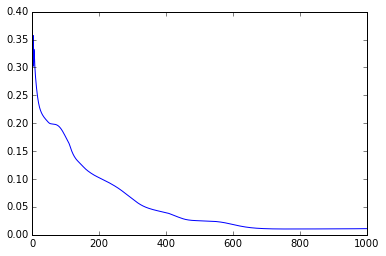

In [186]:
plt.plot(MSE)

In [187]:
data['Predicted'] = predicted_result

In [189]:
def convert_to_pixel(oldValue):
    oldRange = 1 
    newRange = 255 
    newValue = (((oldValue - 0) * newRange) / oldRange) + 0 #oldMin = newMin = 0
    return math.ceil(newValue)

In [190]:
new_value = data['Value'].apply(convert_to_pixel)
new_predicted = data['Predicted'].apply(convert_to_pixel)

In [191]:
data.Value = new_value
data.Predicted = new_predicted
data.head()

,x,y,Value,Predicted
0,0.590191,1.432867,1,-34
1,-0.963482,0.076219,204,166
2,0.119776,0.907827,156,162
3,-0.085859,-1.435880,14,1
4,1.127535,0.783653,80,92


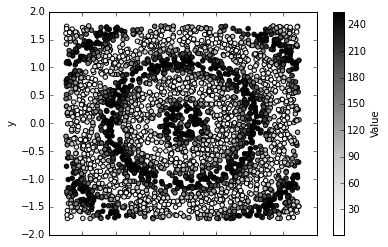

In [192]:
data.plot(kind='scatter',x='x',y='y',c='Value')

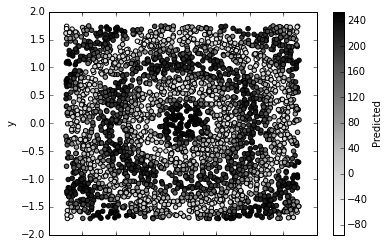

In [193]:
data.plot(kind='scatter',x='x',y='y',c='Predicted')